#### Imports

In [1]:
from dredFISH.Analysis.TissueGraph import *
from dredFISH.Visualization.Viz import *

from MERFISH_Objects.FISHData import *

from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt 

#### Load data

In [2]:
base_path = '/bigstore/Images2021/gaby/dredFISH/DPNMF_PolyA_2021Nov19/'
dataset = 'DPNMF_PolyA_2021Nov19'
fishdata = FISHData(os.path.join(base_path,'fishdata'))
data = fishdata.load_data('h5ad',dataset=dataset)
data.obs_names_make_unique()

data.X = data.layers['total_vectors']
data = data[np.isnan(data.X.max(1))==False]

data.X = data.X/data.obs['total_signal'][:,None]
data.X = data.X - np.array([np.percentile(data.X[:,i],25) for i in range(data.X.shape[1])])
data.X = data.X / np.array([np.percentile(data.X[:,i],75) for i in range(data.X.shape[1])])
data.X = normalize(data.X)

XY = np.asarray([data.obs['stage_y'], data.obs['stage_x']])
XY = np.transpose(XY)
data.obsm['stage'] = XY

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/tmp/ipykernel_2287645/676460092.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  data.X = data.X/data.obs['total_signal'][:,None]


#### Build layers 1-2: cells and zones

In [3]:
TMG = TissueMultiGraph()
TMG.create_cell_and_zone_layers(XY,data.X)


Calling initial optimization
 
 Func-count     x          f(x)          Procedure
    1        11.5208     -7.59055        initial
    2        18.5792     -7.35454        golden
    3        7.15843     -7.71327        golden
    4        4.46235     -7.45825        golden
    5        8.53059     -7.74528        parabolic
    6         8.5223     -7.67645        parabolic
    7        9.67274      -7.6521        golden
    8        8.96685     -7.65772        golden
    9        8.69723     -7.64155        golden
   10        8.59424     -7.77984        golden
   11        8.63358     -7.70373        golden
   12        8.56993     -7.62197        golden
   13        8.60926     -7.65196        golden
   14        8.58495     -7.61984        golden
   15        8.59998     -7.65035        golden
   16        8.59069      -7.6986        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  0.01 )
Number of types: 119 initial

#### Show cond-entropy optimality

In [4]:
EntropyCalcsL1 = TMG.Layers[0].calc_entropy_at_different_Leiden_resolutions()

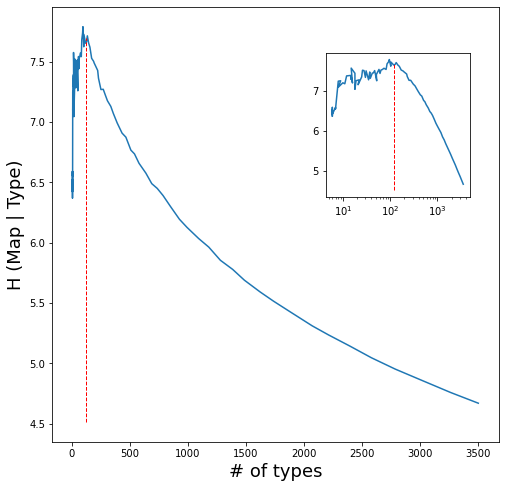

In [34]:
pth='/home/rwollman/MyProjects/MaximallyInformativeBiocartography/FigForSlides/'
fig= plt.figure(figsize = (8,8))
ax1 = plt.gca()
yopt = TMG.cond_entropy[1]
xopt = TMG.Ntypes[1]
ax1.plot(EntropyCalcsL1['Ntypes'],EntropyCalcsL1['Entropy'])
ylm = ax1.get_ylim()
ax1.plot([xopt,xopt],[ylm[0], yopt],'r--',linewidth=1)
ax1.set_xlabel('# of types',fontsize=18)
ax1.set_ylabel('H (Map | Type)',fontsize=18)
fig = plt.gcf()
left, bottom, width, height = [0.6, 0.55, 0.25, 0.25]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.semilogx(EntropyCalcsL1['Ntypes'],EntropyCalcsL1['Entropy'])
ylm = ax2.get_ylim()
ax2.plot([xopt,xopt],[ylm[0], yopt],'r--',linewidth=1)

# fig.savefig(pth + "CondEntL1.png")


#### Build layers 3-4: communities and regions 

In [6]:
TMG.create_communities_and_region_layers(min_neigh_size = 10)


Calling initial optimization
 
 Func-count     x          f(x)          Procedure
    1        11.5208     -2.04401        initial
    2        18.5792     -2.11442        golden
    3        22.9416      -2.1771        golden
    4        25.6376     -2.18442        golden
    5        25.1121     -2.17993        parabolic
    6        27.3039     -2.14335        golden
    7        26.2741     -2.20101        golden
    8        26.6675     -2.15631        golden
    9         26.031     -2.19794        golden
   10        26.3377     -2.17169        parabolic
   11        26.1812     -2.15015        golden
   12        26.2386     -2.11759        golden
   13        26.2984     -2.17353        golden
   14        26.2606     -2.18723        golden
   15        26.2834     -2.13741        golden
   16        26.2689     -2.19108        golden
   17        26.2776     -2.17034        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(u

#### Show cond-entropy optimality

In [7]:
EntropyCalcsL3 = TMG.Layers[2].calc_entropy_at_different_Leiden_resolutions()


In [ ]:
pth='/home/rwollman/MyProjects/MaximallyInformativeBiocartography/FigForSlides/'
fig= plt.figure(figsize = (8,8))
ax1 = plt.gca()
yopt = max(EntropyCalcsL3['Entropy'])
amx = np.argmax(EntropyCalcsL3['Entropy'])
xopt = EntropyCalcsL3['Ntypes'][amx]
ax1.plot(EntropyCalcsL3['Ntypes'],EntropyCalcsL3['Entropy'])
ylm = ax1.get_ylim()
ax1.plot([xopt,xopt],[ylm[0], yopt],'r--',linewidth=1)
ax1.set_xlabel('# of types',fontsize=18)
ax1.set_ylabel('H (Map | Type)',fontsize=18)
fig = plt.gcf()
left, bottom, width, height = [0.6, 0.55, 0.25, 0.25]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.semilogx(EntropyCalcsL3['Ntypes'],EntropyCalcsL3['Entropy'])
ylm = ax2.get_ylim()
ax2.plot([xopt,xopt],[ylm[0], yopt],'r--',linewidth=1)

# fig.savefig(pth + "CondEntL3.png")

#### Add geoms

In [9]:
TMG.add_geoms()
TMG.save('TMG_dev6.pkl')

#### Plot

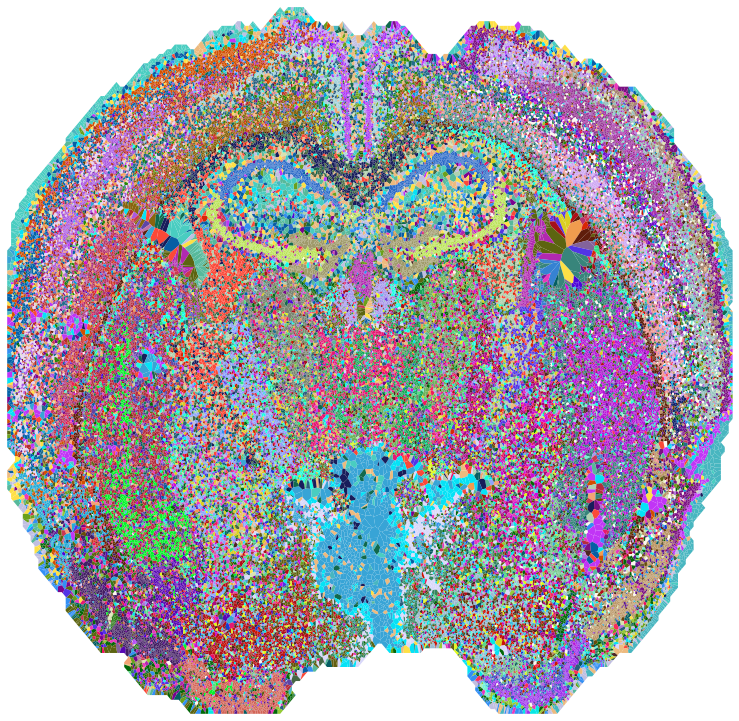

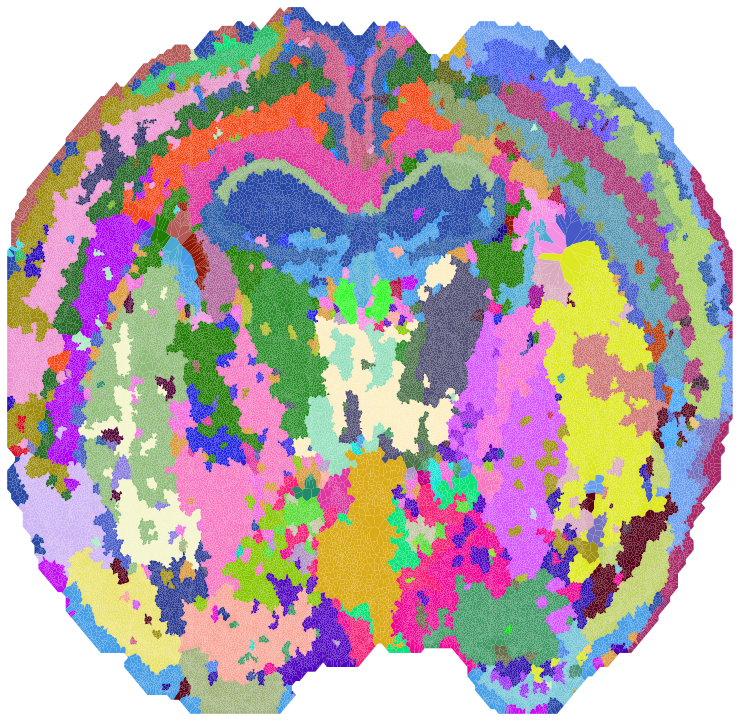

In [10]:
for i in range(1,len(TMG.Layers),2):
    V = RandomPolygonColorByType(TMG,lvl=i)
    V.set_view()
    V.plot()

In [11]:
print(TMG.N)
print(TMG.cond_entropy)
print(TMG.Ntypes)

[97786, 55505, 9527, 686]
[9.798619005423145, 7.699051475487576, 4.77124639942884, 1.488039768967889]
[119, 119, 164, 125]
